# First run eda_customers!

In [43]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_parquet("../data/processed/transactions_canonical.parquet")
a = pd.read_parquet("../data/processed/articles_clean.parquet", columns=["sku", "groupId", 'category', 'brand'])
tx = tx.drop(columns=["invoiceEmail", "orderLineId"], errors="ignore")



In [44]:
print(len(tx))

302219


In [45]:
# ensure sku column names match in both frames; rename if needed
# tx = tx.rename(columns={'articleSku':'sku'})  # example if needed

cols = ["groupId", "sku", "category", "brand"]
a_dedup = a[cols].drop_duplicates(subset=["groupId", "sku"])

tx = tx.merge(
    a_dedup,
    on=["groupId", "sku"],
    how="left",
    validate="many_to_one"  # raises if a still has duplicate (groupId, sku)
)


In [46]:
print(len(tx))

302219


In [47]:
tx.dtypes


orderId                object
shopUserId             object
created                object
currencyId             object
sku                    object
groupId                object
quantity               object
price                  object
name                   object
type                   object
invoiceCity    string[python]
category       string[python]
brand          string[python]
dtype: object

In [48]:
tx.isna().mean()

orderId        0.000000
shopUserId     0.000000
created        0.000000
currencyId     0.000000
sku            0.000000
groupId        0.000000
quantity       0.000000
price          0.000000
name           0.000000
type           0.000000
invoiceCity    0.000000
category       0.028234
brand          0.028234
dtype: float64

In [49]:
# Sample rows where both category and brand are NA
sample_na_cat_brand = tx[tx['category'].isna() & tx['brand'].isna()].sample(5, random_state=42)
sample_na_cat_brand


,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand
167344,535813,594723,2025-01-15 08:41:23,103,970300,970300,1,23,Svarporto,letter,Lødingen,<NA>,<NA>
126729,610408,665379,2025-03-04 13:21:59,50,970300,970300,1,2.3,Vastauspostimerkki,letter,Lohja,<NA>,<NA>
133676,600377,226593,2025-02-25 16:32:43,134,970300,970300,1,18,Svarsporto,letter,Värmdö,<NA>,<NA>
217188,344499,420062,2024-10-09 13:27:03,134,970300,970300,1,18,Svarsporto,letter,Örnsköldsvik,<NA>,<NA>
153941,560095,837764,2025-01-29 08:59:12,103,970300,970300,1,23,Svarporto,letter,Trøgstad,<NA>,<NA>


## Remove known bugs

In [50]:
# Keep only rows where 'created' date is on or after 2024-06-01 to avoid migration bugs
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
tx = tx[tx['created'] >= pd.to_datetime('2024-06-01')]

In [51]:
print(len(tx))

298491


## Unify currenies to SEK for price bucketing

In [52]:
import pandas as pd
import requests

currencyid_to_country = {
    "40":  "DK",
    "134": "SE",
    "103": "NO",
    "50":  "FI",
}

def fetch_sek_rates():
    resp = requests.get(
        "https://api.frankfurter.app/latest",
        params={"from": "EUR", "to": "SEK,DKK,NOK"},
        timeout=10,
    )
    resp.raise_for_status()
    rates = resp.json()["rates"]
    sek_per_eur = rates["SEK"]
    dkk_per_eur = rates["DKK"]
    nok_per_eur = rates["NOK"]
    return {
        "DK": sek_per_eur / dkk_per_eur,
        "NO": sek_per_eur / nok_per_eur,
        "SE": 1.0,
        "FI": sek_per_eur,
    }

tx["currencyId"] = tx["currencyId"].astype("string").str.strip()
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)
conversion_rates = fetch_sek_rates()
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")


In [53]:
tx

,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand,currency_country,sek_rate,price_sek
0,849883,893240,2025-09-22 08:10:46,103,210780-4042,210780,1,298.0,Mønstret halvpolo,telephone,Nybergsund,"Överdelar,Toppar",Åshild,NO,0.944200,281
1,849883,893240,2025-09-22 08:10:46,103,292706,292706,1,311.2,Penisring Bertil Belladot,telephone,Nybergsund,"REA,Lust",Belladot,NO,0.944200,294
2,849883,893240,2025-09-22 08:10:46,103,292086,292086,1,379.0,Vibrator Ester rød Belladot,telephone,Nybergsund,Lust,Belladot,NO,0.944200,358
3,849880,603400,2025-09-22 08:08:42,103,210755-4042,210755,1,175.0,Stripete genser,telephone,Egersund,"Överdelar,Tröjor",Åshild,NO,0.944200,165
4,849880,603400,2025-09-22 08:08:42,103,210733-4042,210733,1,249.0,Strikket jakke,telephone,Egersund,"Koftor,Överdelar",Åshild,NO,0.944200,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298486,166428,252853,2024-06-01 05:23:25,40,261752-0050,260345,1,299.0,Støttetrusse Jaquard&Lace,web,Hornslet,"Underkläder,Gördlar",Miss Mary,DK,1.480472,443
298487,166428,252853,2024-06-01 05:23:25,40,261733-D110,239301,1,599.0,BH uden bøjle Lovely Lace Support,web,Hornslet,"Bh utan bygel,Bh,Underkläder",Miss Mary,DK,1.480472,887
298488,166426,252851,2024-06-01 05:08:51,50,240189-0038,240189,1,49.9,Kuviolliset housut,web,Lempäälä,"Byxor,Nederdelar",Åshild,FI,11.049500,551
298489,166420,252844,2024-06-01 00:58:50,103,263855-4135,263855,1,469.0,Bh uten bøyle,web,Bodø,"Bh utan bygel,Bh,Underkläder",Glamorise,NO,0.944200,443


In [54]:
# Output rows where the price value is 6 digits or more
six_digit_price_rows = tx[tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6,}')]
six_digit_price_rows


,orderId,shopUserId,created,currencyId,sku,groupId,quantity,price,name,type,invoiceCity,category,brand,currency_country,sek_rate,price_sek
161521,545774,604121,2025-01-20 13:51:07,40,266825-C080,266825,1,449399.0,BH uden bøjle Treasure,telephone,Roskilde,"Bh utan bygel,Bh,Underkläder",Swegmark,DK,1.480472,665322


In [55]:
# Remove rows where the price value is 6 digits
tx = tx[~tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')]

Price (SEK) statistics (1st to 99th percentile):
  Count: 293,171
  Mean: 285.74
  Median: 235.00
  Std: 193.83
  Min (1st percentile): 18.00
  Max (99th percentile): 1,103.00


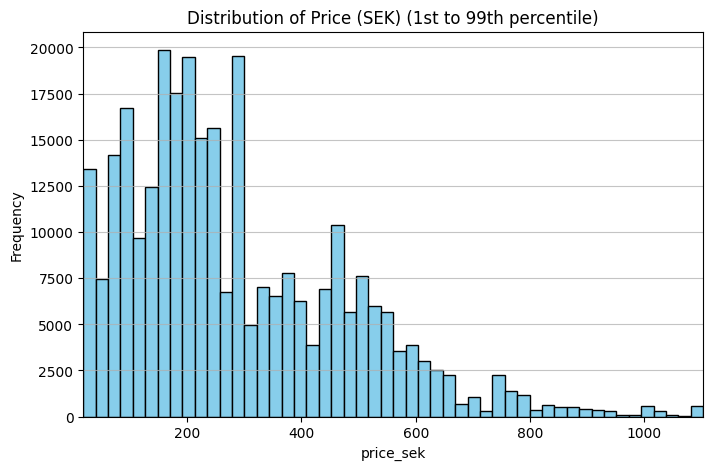

In [56]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
q_low = price_sek.quantile(0.01)
q_high = price_sek.quantile(0.99)
price_sek_trimmed = price_sek[(price_sek >= q_low) & (price_sek <= q_high)]

print("Price (SEK) statistics (1st to 99th percentile):")
print(f"  Count: {price_sek_trimmed.count():,}")
print(f"  Mean: {price_sek_trimmed.mean():,.2f}")
print(f"  Median: {price_sek_trimmed.median():,.2f}")
print(f"  Std: {price_sek_trimmed.std():,.2f}")
print(f"  Min (1st percentile): {q_low:,.2f}")
print(f"  Max (99th percentile): {q_high:,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek_trimmed, 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK) (1st to 99th percentile)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(q_low, q_high)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [57]:
# Read the cleaned customers data from Parquet, do not change dtypes
customers = pd.read_parquet("../data/processed/customers_clean.parquet")

# Merge the 'Age' and 'invoiceCity' columns from the customers dataframe into the transactions dataframe, matching on 'shopUserId'
# This adds the 'Age' and 'invoiceCity' information for each transaction, using a left join to keep all transactions
tx = tx.merge(customers[["shopUserId", "Age", "Gender"]], on="shopUserId", how="left")

In [58]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
groupId             0.000000
quantity            0.000000
price               0.000003
name                0.000000
type                0.000000
invoiceCity         0.000000
category            0.028587
brand               0.028587
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000003
Age                 0.358565
Gender              0.358565
dtype: float64

In [59]:
print("Unique values in 'type' column:", tx["type"].unique())


Unique values in 'type' column: ['telephone' 'web' 'letter' 'email' 'other']


# Line price

In [60]:
# Convert 'quantity' to numeric, round to nearest integer, and convert back to string (if needed)
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").round().astype("Int64").astype(str)


In [61]:
print("Unique values of quantity:", tx["quantity"].unique())


Unique values of quantity: ['1' '3' '2' '5' '4' '9' '6' '7' '12' '8' '11' '10' '15' '16' '50' '176'
 '130' '19' '40' '20' '14' '229' '24' '18' '25' '999' '<NA>']


In [62]:
# Calculate line_total_sek as price_sek * quantity, ensuring both are numeric, rounded to nearest integer (no decimals), and drop rows where result is NA or 0
tx["price_sek"] = pd.to_numeric(tx["price_sek"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")
tx["line_total_sek"] = (tx["price_sek"] * tx["quantity"]).round()
# Ensure line_total_sek is numeric
tx["line_total_sek"] = pd.to_numeric(tx["line_total_sek"], errors="coerce")
# Drop rows where line_total_sek is NA or 0
tx = tx.dropna(subset=["line_total_sek"])
tx = tx[tx["line_total_sek"] != 0]


# Country remap COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}

In [63]:
COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}
tx["currency_country"] = tx["currency_country"].map(COUNTRY_MAP_ALPHA).fillna(tx["currency_country"])


In [64]:
print("Number of unique invoiceCity values:", tx["invoiceCity"].nunique())
print("Value counts for invoiceCity:")
print(tx["invoiceCity"].value_counts(dropna=False))


Number of unique invoiceCity values: 4873
Value counts for invoiceCity:
invoiceCity
Oslo         8368
Helsinki     3521
Stockholm    2571
Göteborg     2256
Uppsala      2017
             ... 
Fegen           1
Jordrup         1
Hellebæk        1
Osloos          1
Oravala         1
Name: count, Length: 4873, dtype: Int64


In [65]:
# Check if there are different case spellings of 'oslo' in invoiceCity (non-null)
oslo_cities = tx["invoiceCity"].dropna()
oslo_variants = set(city for city in oslo_cities if isinstance(city, str) and city.lower() == "oslo")
if len(oslo_variants) > 1:
    print("Different case spellings of 'oslo' found in invoiceCity:")
    for city in sorted(oslo_variants):
        print(city)
elif len(oslo_variants) == 1:
    print("Only one case spelling of 'oslo' found in invoiceCity:", list(oslo_variants)[0])
else:
    print("No 'oslo' found in invoiceCity.")


Only one case spelling of 'oslo' found in invoiceCity: Oslo


In [66]:
# Save cleaned transactions to Parquet without changing dtypes
tx.to_parquet("../data/processed/transactions_clean.parquet", index=False)

In [67]:
# Output the proportion of NA (missing) values for each column in tx
print(tx.isna().mean())


orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
groupId             0.000000
quantity            0.000000
price               0.000000
name                0.000000
type                0.000000
invoiceCity         0.000000
category            0.028607
brand               0.028607
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.358928
Gender              0.358928
line_total_sek      0.000000
dtype: float64


# Orders

In [25]:
import pandas as pd, gc

# --- customers: collapse duplicates, map ---
cust = pd.read_parquet("../data/processed/customers_clean.parquet",
                       columns=["shopUserId","invoiceCity","Gender"])
cust = cust.groupby("shopUserId", as_index=False).first()  # ensure unique key
tx["shopUserId"] = tx["shopUserId"].astype(cust["shopUserId"].dtype)
m_city = dict(zip(cust["shopUserId"], cust["invoiceCity"]))
m_gen  = dict(zip(cust["shopUserId"], cust["Gender"]))
tx["invoiceCity"] = tx["shopUserId"].map(m_city)
tx["Gender"] = tx["shopUserId"].map(m_gen)
del cust, m_city, m_gen; gc.collect()

# --- articles: collapse duplicates, map ---
arts = pd.read_parquet("../data/processed/articles_clean.parquet",
                       columns=["groupId","category","brand"])
arts = arts.groupby("groupId", as_index=False).first()     # ensure unique key
tx["groupId"] = tx["groupId"].astype(arts["groupId"].dtype)

if "category" in arts.columns:
    m_cat = dict(zip(arts["groupId"], arts["category"]))
    tx["category"] = tx["groupId"].map(m_cat)

if "brand" in arts.columns:
    m_br = dict(zip(arts["groupId"], arts["brand"]))
    tx["brand"] = tx["groupId"].map(m_br)

del arts; gc.collect()


0

In [26]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

tx = tx.copy()

# --- 1) Tidy dtypes (concise) ---
str_cols = ["orderId", "shopUserId", "currencyId", "sku", "name", "groupId"]
tx[str_cols] = tx[str_cols].apply(lambda s: s.astype("string[python]").str.strip())

tx["created"]  = pd.to_datetime(tx["created"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").fillna(1).clip(lower=1).round().astype("Int64")
tx["price"]    = pd.to_numeric(tx["price"], errors="coerce").astype("Float64")
tx["sek_rate"] = pd.to_numeric(tx.get("sek_rate"), errors="coerce")  # float64

# Optional: price in SEK (two decimals). If you want integers, round later.
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(2)

# Line total in SEK rounded to nearest krona (integer)
tx["_line_total"] = (tx["price_sek"] * tx["quantity"]).round().astype("Int64")

# --- 2) One row per orderId ---
orders = (
    tx.sort_values(["orderId", "created"])
      .groupby("orderId", as_index=False)
      .agg(
          shopUserId    = ("shopUserId", "first"),
          order_created = ("created", "min"),
          total_qty     = ("quantity", "sum"),
          basket_value  = ("_line_total", "sum"),
          currencyId    = ("currencyId", "first")
      )
)

# Ensure ints and compute avg unit price (integer)
orders["total_qty"]    = orders["total_qty"].astype(int)
orders["basket_value"] = orders["basket_value"].astype(int)
orders["avg_unit_price"] = (orders["basket_value"] / orders["total_qty"]).round().astype(int)

# --- 3) Lists per order (unique, sorted) ---
sku_list = (
    tx.groupby("orderId")["sku"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("sku_list")
)
groupid_list = (
    tx.groupby("orderId")["groupId"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("groupid_list")
)

orders = orders.merge(sku_list, on="orderId", how="left") \
               .merge(groupid_list, on="orderId", how="left")


In [27]:
# Number of orders
len(orders)


105901

In [28]:
orders.dtypes

orderId           string[python]
shopUserId        string[python]
order_created     datetime64[ns]
total_qty                  int64
basket_value               int64
currencyId        string[python]
avg_unit_price             int64
sku_list                  object
groupid_list              object
dtype: object

In [29]:
# Number of unique users
tx["shopUserId"].nunique()

60159

Users: 60159 | Sum of bins: 60159


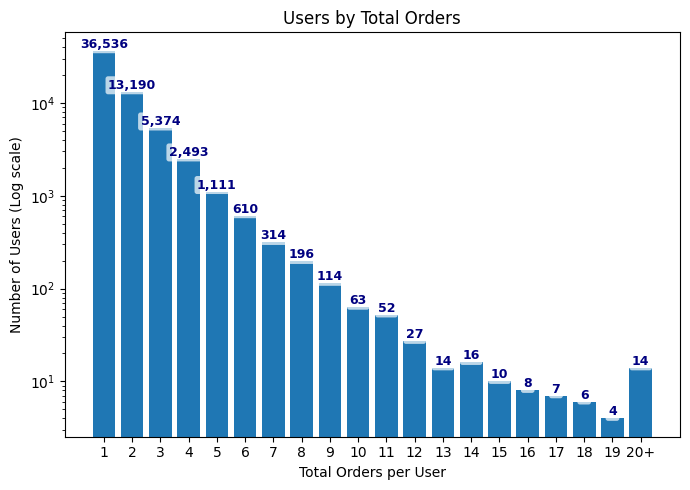

In [30]:
# total orders per user (one value per user)
n_orders_per_user = orders.groupby('shopUserId').size()

# bins: [1,2), [2,3), ..., [19,20), [20, inf)  -> label '20+' includes 20, 21, ...
bins   = list(range(1, 20)) + [20, float('inf')]
labels = [str(i) for i in range(1, 20)] + ['20+']

cats = pd.cut(n_orders_per_user, bins=bins, right=False, labels=labels, ordered=True)

# counts in the exact label order (no string sorting issues)
counts = cats.value_counts().reindex(labels, fill_value=0)

# sanity checks
assert counts.sum() == n_orders_per_user.size, "Counts should sum to #users"
print("Users:", n_orders_per_user.size, "| Sum of bins:", int(counts.sum()))

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
bars = plt.bar(labels, counts.values)
plt.yscale('log')  # optional; remember zeros won't show on log scale
plt.title('Users by Total Orders')
plt.xlabel('Total Orders per User')
plt.ylabel('Number of Users (Log scale)')

# annotate bars with more readable numbers (with thousands separator and horizontal orientation)
for i, v in enumerate(counts.values):
    if v > 0:
        plt.text(
            i, v, f'{int(v):,}', 
            ha='center', va='bottom', 
            rotation=0, fontsize=9, 
            fontweight='bold', color='navy',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()


“time to come back” (in days) between a user’s consecutive orders, buckets those gaps, and plots the distribution.

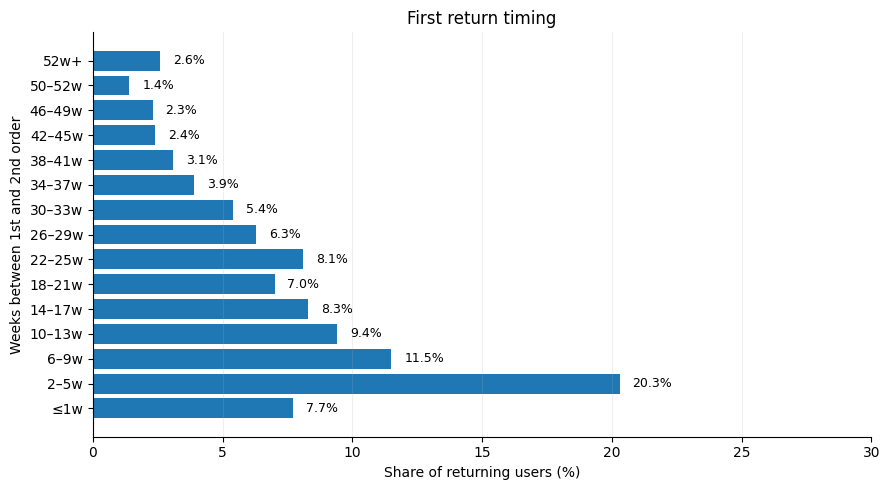

{'returning_users_denominator': 23623, 'rates_by_bucket_%': {'≤1w': 7.7, '2–5w': 20.3, '6–9w': 11.5, '10–13w': 9.4, '14–17w': 8.3, '18–21w': 7.0, '22–25w': 8.1, '26–29w': 6.3, '30–33w': 5.4, '34–37w': 3.9, '38–41w': 3.1, '42–45w': 2.4, '46–49w': 2.3, '50–52w': 1.4, '52w+': 2.6}, 'counts_by_bucket': {'≤1w': 1821, '2–5w': 4805, '6–9w': 2726, '10–13w': 2223, '14–17w': 1972, '18–21w': 1664, '22–25w': 1913, '26–29w': 1498, '30–33w': 1287, '34–37w': 932, '38–41w': 721, '42–45w': 576, '46–49w': 537, '50–52w': 336, '52w+': 612}}


In [31]:
# --- First return ONLY: weekly bins (≤1w, then 4-week bins) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

time_col = 'order_created'  # change if needed

# Prep & sort
orders[time_col] = pd.to_datetime(orders[time_col], errors='coerce', utc=True)
df = orders.dropna(subset=[time_col]).sort_values(['shopUserId', time_col]).copy()

# First return gaps (1st -> 2nd order), in WEEKS
df['next_time'] = df.groupby('shopUserId')[time_col].shift(-1)
df['gap_days']  = (df['next_time'] - df[time_col]).dt.total_seconds() / 86400.0
df['order_idx'] = df.groupby('shopUserId').cumcount()
first_ret = df.loc[df['order_idx'] == 0, ['shopUserId', 'gap_days']].dropna().copy()
first_ret = first_ret[first_ret['gap_days'] >= 0]
first_ret['gap_weeks'] = first_ret['gap_days'] / 7.0

# Bin edges in WEEKS: (0–1], (1–5], (5–9], ... up to 52, then inf
edges_w = [0, 1]
cur = 1
while cur < 52:
    cur += 4
    edges_w.append(min(cur, 52))
edges_w = sorted(set(edges_w))
if edges_w[-1] < 52:
    edges_w.append(52)
edges_w.append(np.inf)

# Labels aligned to right-closed intervals
labels = []
for a, b in zip(edges_w[:-1], edges_w[1:]):
    if np.isinf(b):
        labels.append('52w+')
    elif a == 0:
        labels.append('≤1w')
    else:
        labels.append(f'{int(a)+1}–{int(b)}w')

# Bucket (right=True → (a,b], include_lowest=True → [0,b] for first bin)
first_ret['bucket'] = pd.cut(
    first_ret['gap_weeks'],
    bins=edges_w, right=True,
    include_lowest=True,
    labels=labels, ordered=True
)

# Rates among returners (denominator = returning users only)
counts = first_ret['bucket'].value_counts().reindex(labels, fill_value=0)
total  = int(counts.sum())
rates  = (counts / total * 100).round(1) if total > 0 else counts.astype(float)

# Plot: horizontal bars (compact)
fig, ax = plt.subplots(figsize=(9,5))
ypos = np.arange(len(labels))
bars = ax.barh(labels, rates.values)

# Minimal, readable annotations (percent only)
for rect, pct in zip(bars, rates.values):
    ax.text(rect.get_width() + 0.5, rect.get_y() + rect.get_height()/2,
            f"{pct:.1f}%", va='center', ha='left', fontsize=9)

# Tidy aesthetics
ax.set_xlim(0, max(10, math.ceil((rates.max() if total>0 else 0) / 5.0) * 5 + 5))
ax.set_xlabel('Share of returning users (%)')
ax.set_ylabel('Weeks between 1st and 2nd order')
ax.set_title('First return timing')
ax.grid(axis='x', alpha=0.2)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

print({
    "returning_users_denominator": total,
    "rates_by_bucket_%": rates.to_dict(),
    "counts_by_bucket": counts.to_dict()
})
